In [23]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from pgmpy.inference import VariableElimination
import warnings
import json
warnings.filterwarnings("ignore")

In [24]:

with open("../../../../data/Weakness.json", 'r+') as weakfile:
    weak = json.load(weakfile)
    weakfile.close()
    
def Generate_Multiplicator(x):
    EnemyType = x["Enemy Type"]
    MoveType = x["Type Move"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    for i in range(len(EnemyType)):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
        elif i == 1:
            EnemyType[1] = EnemyType[1][2:-2]
    for Type in EnemyType:
        if not Type.isalnum():
            continue
        weakness = weakness * weak[MoveType][Type] 
    return weakness

def percentual_Transform(s):
    
    l = s.split("\/")
    l = list(map(lambda n: int(n),l))
    p = l[0]/l[1] * 100
    
    return p

def check_stab(df):
    new_col = []
    for i in range(len(df)):
        if df['Pokemon Type'][i].split('\'')[1] == df['Type Move'][i] or (len(df['Pokemon Type'][i].split('\'')) > 3 and df['Pokemon Type'][i].split('\'')[3] == df['Type Move'][i]):
            new_col.append(True)
        else:
            new_col.append(False)
    df = df.assign(stab=new_col)
    df = df.drop(['Pokemon Type', 'Type Move'], axis= 1)
    return df

In [25]:
df = pd.read_csv("../parsing Dataset/log/Dataset.csv")

df["UserHP"] = df["UserHP"].map(percentual_Transform)
df["SuffererHP"] = df["SuffererHP"].map(percentual_Transform)

df.rename({"UserHP": "Pokemon HP","SuffererHP": "Enemy HP","TypeM": "Type Move",
           "categoryMove": "Category","TypesS" : "Enemy Type","TypesU":"Pokemon Type",
           "power":"Power"}, axis=1, inplace=True)
df["Multiplicator"] = df[["Enemy Type","Type Move"]].apply(Generate_Multiplicator, axis=1)
df = df.drop(["Enemy Type"], axis= 1)
#df["Choose"] = np.ones(len(df)).astype(int)
df = check_stab(df)
df["Weather"] = df["Weather"].str.rstrip().str.lower()
df["Status enemy"] = df["Status enemy"].str.rstrip().str.lower()
df["Sufferer"] = df["Sufferer"].str.rstrip().str.lower()
df["User"] = df["User"].str.rstrip().str.lower()
df

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab
0,klinklang,klinklang,Substitute,0,100.000000,100.000000,none,status,normal,1.0,1.0,False
1,hydreigon,klinklang,U-turn,70,100.000000,100.000000,none,physical,normal,1.0,1.0,False
2,klinklang,emboar,Return,102,100.000000,100.000000,none,physical,normal,1.0,1.0,False
3,klinklang,emboar,Substitute,0,100.000000,100.000000,none,status,normal,0.0,1.0,False
4,emboar,klinklang,Fire Blast,110,100.000000,100.000000,none,special,normal,1.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2748,persian,persian,Nasty Plot,0,100.000000,100.000000,none,status,par,1.0,1.0,False
2749,entei,persian,Sacred Fire,100,72.638436,100.000000,none,physical,par,1.0,1.0,True
2750,persian,entei,Dark Pulse,80,100.000000,72.638436,none,special,psn,1.0,1.0,False
2751,persian,entei,Nasty Plot,0,100.000000,100.000000,none,status,psn,0.0,1.0,False


In [26]:
from sklearn.preprocessing import KBinsDiscretizer

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Pokemon HP"]])
df["Pokemon HP"] = enc.transform(df[["Pokemon HP"]]).astype(int)
enc.fit(df[["Enemy HP"]])
df["Enemy HP"] = enc.transform(df[["Enemy HP"]]).astype(int)
enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Power"]])
df["Power"] = enc.transform(df[["Power"]]).astype(int)
df

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab
0,klinklang,klinklang,Substitute,0,4,4,none,status,normal,1.0,1.0,False
1,hydreigon,klinklang,U-turn,1,4,4,none,physical,normal,1.0,1.0,False
2,klinklang,emboar,Return,2,4,4,none,physical,normal,1.0,1.0,False
3,klinklang,emboar,Substitute,0,4,4,none,status,normal,0.0,1.0,False
4,emboar,klinklang,Fire Blast,2,4,4,none,special,normal,1.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2748,persian,persian,Nasty Plot,0,4,4,none,status,par,1.0,1.0,False
2749,entei,persian,Sacred Fire,2,2,4,none,physical,par,1.0,1.0,True
2750,persian,entei,Dark Pulse,1,4,2,none,special,psn,1.0,1.0,False
2751,persian,entei,Nasty Plot,0,4,4,none,status,psn,0.0,1.0,False


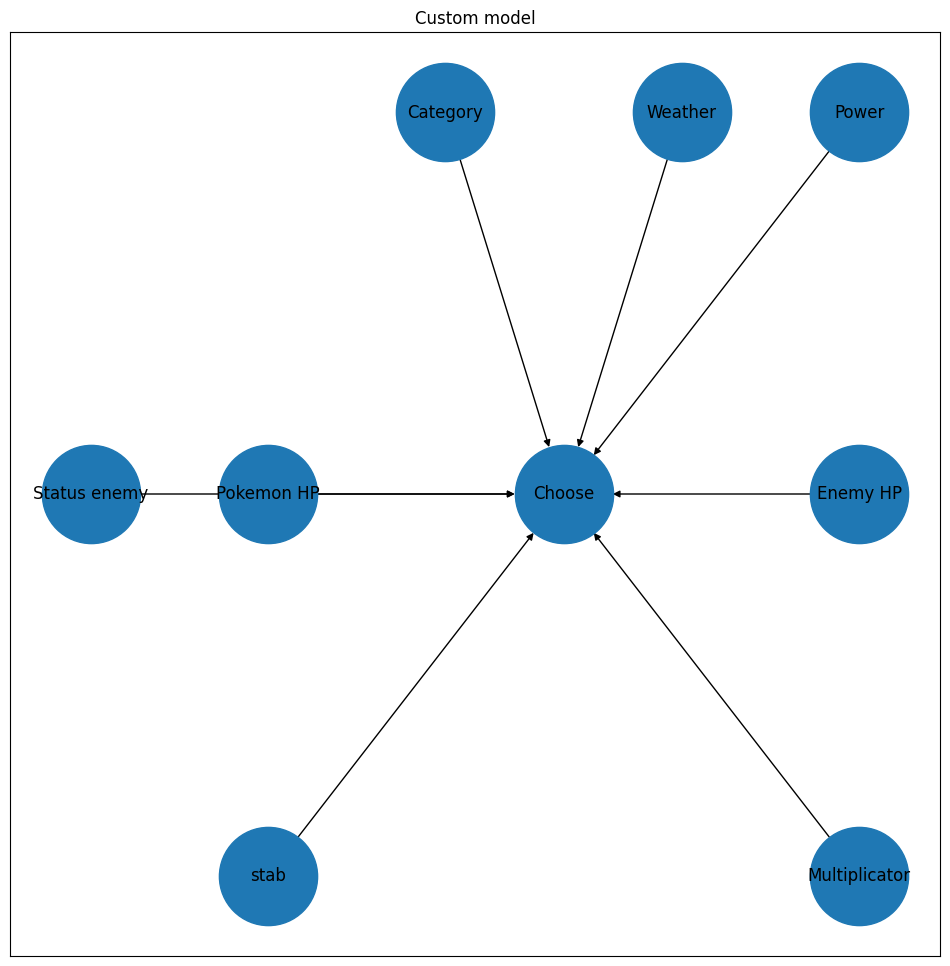

In [27]:
custom_model = BayesianNetwork([('Pokemon HP', 'Choose'), ('Enemy HP', 'Choose'), ('Status enemy', 'Choose'),
                              ('stab', 'Choose'), ('Multiplicator', 'Choose'), ('Power', 'Choose'),
                               ("Weather","Choose"), ("Category","Choose")])
pos = {'Pokemon HP': [0.75, -0.5], 'Enemy HP': [1.25, -0.5],
       "stab": [0.75, -1.], 'Multiplicator': [1.25, -1],
       'Power': [1.25, 0], "Weather" : [1.1, 0],
       'Choose': [1, -0.5],"Category" : [0.9, 0], "Status enemy" : [0.6, -0.5]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

In [28]:

estimator = BayesianEstimator(model=custom_model, data=df)

cpds = []
for node in custom_model.nodes():
    cpds.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=10))
    

custom_model.add_cpds(*cpds)

print('Checking the model...')
print(f'The model is {custom_model.check_model()}\n\n')

for cpd in [cpd for cpd in custom_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)
    
choose = custom_model.get_cpds("Choose")
print(choose)

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+-----------+
| Pokemon HP(0) | 0.0188201 |
+---------------+-----------+
| Pokemon HP(1) | 0.0488599 |
+---------------+-----------+
| Pokemon HP(2) | 0.0770901 |
+---------------+-----------+
| Pokemon HP(3) | 0.107492  |
+---------------+-----------+
| Pokemon HP(4) | 0.747738  |
+---------------+-----------+
CPD for Choose:
+---------------+-----+--------------------+
| Category      | ... | Category(status)   |
+---------------+-----+--------------------+
| Enemy HP      | ... | Enemy HP(4)        |
+---------------+-----+--------------------+
| Multiplicator | ... | Multiplicator(4.0) |
+---------------+-----+--------------------+
| Pokemon HP    | ... | Pokemon HP(4)      |
+---------------+-----+--------------------+
| Power         | ... | Power(4)           |
+---------------+-----+--------------------+
| Status enemy  | ... | Status enemy(tox)  |
+---------------+-----+--------------------+
| Weath

In [46]:
import time

EVIDENCE = {'Power': 2,
            'Multiplicator': 2,
            'stab': True,
            'Enemy HP': 1,
            "Pokemon HP": 4,
            "Category": "physical",
            "Weather": "none",
            "Status enemy": "normal"
            }

ordering_heuristics = ['MinFill', 'MinNeighbors','MinWeight','WeightedMinFill']
inference = VariableElimination(custom_model)

def run_query(target_var, evidence, print_output=True):
    probs = []
    for order in ordering_heuristics:
        if print_output:
            print('Using ' + order)
        start = time.time()
        prob = inference.query([target_var],
                              evidence,
                              elimination_order=order,
                              show_progress=False)
        probs.append(prob.get_value(Choose = 1))
        end = time.time() - start
        if print_output:
            print(prob)
            print('----- Query solved in {:.4f} seconds -----\n\n'.format(end))
    return probs

In [47]:
result = run_query(target_var='Choose', evidence=EVIDENCE)
print(result[0])

Using MinFill
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.0000 |
+-------------+---------------+
| Choose(1.0) |        1.0000 |
+-------------+---------------+
----- Query solved in 0.1926 seconds -----


Using MinNeighbors
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.0000 |
+-------------+---------------+
| Choose(1.0) |        1.0000 |
+-------------+---------------+
----- Query solved in 0.1640 seconds -----


Using MinWeight
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.0000 |
+-------------+---------------+
| Choose(1.0) |        1.0000 |
+-------------+---------------+
----- Query solved in 0.2216 seconds -----


Using WeightedMinFill
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.0

In [ ]:
df_switch = pd.read_csv("../parsing Dataset/log/Dataset-Switch.csv")

def Generate_Multiplicator_In_switch(x):
    EnemyType = x["Enemy Type"]
    InType = x["Pokemon In Type"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    InType = InType.split(",")

    for i in range(max(len(EnemyType), len(InType))):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
            InType[i] = InType[i][2:-1]
        elif i == 1:
            if len(EnemyType) > 1:
                EnemyType[1] = EnemyType[1][2:-2]
            if len(InType) > 1:
                InType[1] = InType[1][2:-2]
    for En_Type in EnemyType:
        if not En_Type.isalnum():
            continue
        for In_Type in InType:
            if not In_Type.isalnum():
                continue
            weakness = weakness * weak[In_Type][En_Type] 
    return weakness

def Generate_Multiplicator_Out_switch(x):
    EnemyType = x["Enemy Type"]
    OutType = x["Pokemon Out Type"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    OutType = OutType.split(",")

    for i in range(max(len(EnemyType), len(OutType))):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
            OutType[i] = OutType[i][2:-1]
        elif i == 1:
            if len(EnemyType) > 1:
                EnemyType[1] = EnemyType[1][2:-2]
            if len(OutType) > 1:
                OutType[1] = OutType[1][2:-2]
    for En_Type in EnemyType:
        if not En_Type.isalnum():
            continue
        for Out_Type in OutType:
            if not Out_Type.isalnum():
                continue
            weakness = weakness * weak[Out_Type][En_Type] 
    return weakness

df_switch["HPout"] = df_switch["HPout"].map(percentual_Transform)
df_switch["HPEnemy"] = df_switch["HPEnemy"].map(percentual_Transform)
df_switch["Weather"] = df_switch["Weather"].str.rstrip().str.lower()
df_switch["StatusP"] = df_switch["StatusP"].str.rstrip().str.lower()

df_switch.rename({"HPout": "Pokemon HP","HPEnemy": "Enemy HP","TypeEnemy" : "Enemy Type","TypeIN":"Pokemon In Type", "TypeOUT":"Pokemon Out Type", "StatusP":"Status Pokemon"}, axis=1, inplace=True)
df_switch["Multiplicator In"] = df_switch[["Enemy Type", "Pokemon In Type"]].apply(Generate_Multiplicator_In_switch, axis=1)
df_switch["Multiplicator Out"] = df_switch[["Enemy Type", "Pokemon Out Type"]].apply(Generate_Multiplicator_Out_switch, axis=1)

df_switch = df_switch.drop(["Enemy Type", "Pokemon In Type", "Pokemon Out Type"], axis= 1)

df_switch

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='uniform')
enc.fit(df_switch[["Pokemon HP"]])
df_switch["Pokemon HP"] = enc.transform(df_switch[["Pokemon HP"]]).astype(int)
enc.fit(df_switch[["Enemy HP"]])
df_switch["Enemy HP"] = enc.transform(df_switch[["Enemy HP"]]).astype(int)
df_switch

In [ ]:
switch_model = BayesianNetwork([('Pokemon HP', 'Switch'), ('Enemy HP', 'Switch'), ('Status Pokemon', 'Switch'), ('Weather', 'Switch'), ('Multiplicator In', 'Switch'), ('Multiplicator Out', 'Switch')])
pos = {'Pokemon HP': [0.9, 0], 'Enemy HP': [1.1, 0],
       "Multiplicator Out": [0.75, 0], 'Multiplicator In': [1.25, 0],
       'Switch': [1, -0.5], 'Status Pokemon' : [0.9, -1], 'Weather' : [1.25, -1]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(switch_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

In [ ]:

estimator = BayesianEstimator(model=switch_model, data=df_switch)

cpds = []
for node in switch_model.nodes():
    cpds.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=10))
switch_model.add_cpds(*cpds)

print('Checking the model...')
print(f'The model is {switch_model.check_model()}\n\n')

for cpd in [cpd for cpd in switch_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)
    
choose = switch_model.get_cpds("Switch")
print(choose)

In [ ]:
import time

EVIDENCE = {'Multiplicator In': 2,
            'Multiplicator Out': 0.5,
            'Enemy HP': 1,
            "Pokemon HP": 9}

ordering_heuristics = ['MinFill', 'MinNeighbors','MinWeight','WeightedMinFill']
inference = VariableElimination(switch_model)

def switch_run_query(target_var, evidence, print_output=True):
    probs = []
    for order in ordering_heuristics:
        if print_output:
            print('Using ' + order)
        start = time.time()
        prob = inference.query([target_var],
                              evidence,
                              elimination_order=order,
                              show_progress=False)
        probs.append(prob.get_value(Switch = 1))
        end = time.time() - start
        if print_output:
            print(prob)
            print('----- Query solved in {:.4f} seconds -----\n\n'.format(end))
    return probs

In [ ]:
result = switch_run_query(target_var='Switch', evidence=EVIDENCE)
print(result[0])